In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 1. Load the file data.csv, explore the data showing size and do some data exploration, the dataset is unsupervised

In [64]:
url = "/content/Feb25data.csv"

In [65]:
df = pd.read_csv(url , sep = '\t' )

In [66]:
df.head()

,F0,F1,F2
0,d,a,a
1,c,e,c
2,j,a,c
3,f,e,j
4,c,e,d


In [67]:
df.describe(include = "all")

,F0,F1,F2
count,1000,1000,1000
unique,10,10,10
top,d,e,e
freq,100,101,101


In [68]:
df.shape

(1000, 3)

# 2. Do the appropriate pre-processing in order to use the sklearn algorithms on this dataset; the values are qualitative and must be considered as nominal

In [69]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse_output=False)
enc.fit(df)
x_tr = pd.DataFrame(enc.transform(df) , columns = enc.get_feature_names_out(df.columns) )

In [70]:
x_tr.head()

,F0_a,F0_b,F0_c,F0_d,F0_e,F0_f,F0_g,F0_h,F0_i,F0_j,...,F2_a,F2_b,F2_c,F2_d,F2_e,F2_f,F2_g,F2_h,F2_i,F2_j
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3. In this dataset the elbow method will show an almost “vanishing” elbow for inertia, and the silhouette is totally non-effective. As external background knowledge, we are told that here a requirement for a good clustering scheme is to have clusters with balanced cluster sizes, e.g. ascheme with cluster sizes (333, 667) is less acceptable than one with (333, 333, 334). In order to obtain this, we to compute, for each clustering scheme a Balanced Partition Index (BPI) computed from the cluster sizes with the function defined in the attached file. BPI values range from 0=worst index to 1=best index. For varying n_clusters fit KMeans and compute the inertia, the silhouette index, and the above mentioned BPI.

In [71]:
import numpy as np

def bpi(cluster_sizes):
    """
    Balanced Partition Index (BPI)

    Parameters
    ----------
    cluster_sizes : array-like
        Sizes of clusters, e.g. [333, 333, 334]

    Returns
    -------
    float
        Value in [0,1]
        1  -> perfectly balanced clusters
        0  -> highly unbalanced clusters
    """
    sizes = np.array(cluster_sizes, dtype=float)

    if len(sizes) <= 1:
        return 0.0

    mean_size = np.mean(sizes)

    # Total deviation from perfect balance (normalized)
    imbalance = np.sum(np.abs(sizes - mean_size)) / (2 * len(sizes) * mean_size)

    # Convert imbalance to balance score
    return 1.0 - imbalance


In [72]:
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
k_range = list(range(2,14))
param_grid = {'n_clusters' : k_range }
pg = list(ParameterGrid(param_grid))

In [73]:
sil_score = []
inertia_km = []
bpi_score = []
all_sizes = []
for i in range(len(pg)):
  km = KMeans(**(pg[i]) , random_state=42)
  y_km = km.fit_predict(x_tr)
  cluster_sizes = np.unique(y_km , return_counts = True)[1] #we just want counts not labels
  sil_score.append(silhouette_score(x_tr , y_km))
  inertia_km.append(km.inertia_)
  all_sizes.append(cluster_sizes)
  bpi_score.append(bpi(cluster_sizes))


Since we are going to find the k , on basis of bpi as this tells us better about clusters rather than silhoutte and inertia

In [74]:
best_idx = np.argmax(bpi_score)     # index of best BPI
best_k = k_range[best_idx]          # the corresponding k value

print("Best k by BPI:", best_k)
print("Best BPI:", bpi_score[best_idx])
print("Cluster sizes at best k:", all_sizes[best_idx])
print("Silhouette at best k:", sil_score[best_idx])
print("Inertia at best k:", inertia_km[best_idx])


Best k by BPI: 10
Best BPI: 0.948
Cluster sizes at best k: [ 66 100  93 132 120 100 100 100  93  96]
Silhouette at best k: 0.1777265516215153
Inertia at best k: 1746.3439345063534


# 4. Make two plots, one with inertia and silhouette, another with inertia and BPI, then decide the best number of clusters and refit KMeans using that value

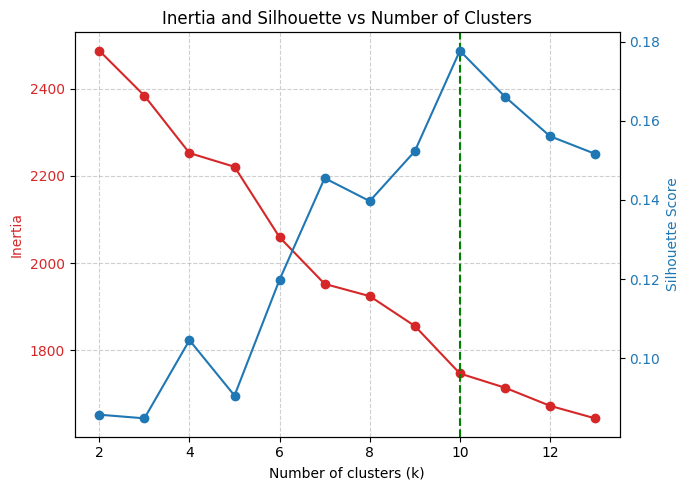

In [75]:
fig, ax1 = plt.subplots(figsize=(7,5))

color = 'tab:red'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_range, inertia_km, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k_range, sil_score, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

ax1.axvline(best_k, color='green', linestyle='--')

plt.title("Inertia and Silhouette vs Number of Clusters")
fig.tight_layout()
plt.show()


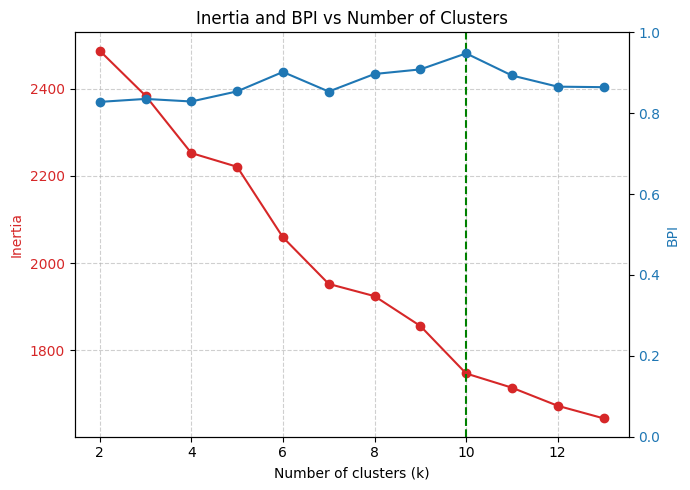

In [76]:
fig, ax1 = plt.subplots(figsize=(7,5))

color = 'tab:red'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_range, inertia_km, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('BPI', color=color)
ax2.plot(k_range, bpi_score, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1)

ax1.axvline(best_k, color='green', linestyle='--')

plt.title("Inertia and BPI vs Number of Clusters")
fig.tight_layout()
plt.show()


#I am gonna refit the best hyperparams for kmeans

In [77]:
km_f = KMeans(n_clusters=10 , random_state=42)
y_km_f = km_f.fit_predict(x_tr)
print("The silhoutte score is ," , silhouette_score(x_tr , y_km_f))
print("The inertia value is" , km_f.inertia_ )
print("The bpi value is" , bpi(np.unique(y_km_f , return_counts = True)[1]))

The silhoutte score is , 0.1777265516215153
The inertia value is 1746.3439345063534
The bpi value is 0.948


# 5. Repeat the experiment using a different clustering algorithm of your choice, trying to generate a number of clusters near the one chosen in step 4 and show the results with the best hyperparameter values.

In [105]:
from sklearn.cluster import AgglomerativeClustering

k_range = list(range(2, 15))
parameters = [{
    'n_clusters': k_range,
    'linkage': ['ward', 'complete', 'average', 'single']
}]
pg = list(ParameterGrid(parameters))


result_ac = []
for i in range(len(pg)):

    ac = AgglomerativeClustering(**pg[i])
    y_ac = ac.fit_predict(x_tr)

    cluster_sizes = np.unique(y_ac, return_counts=True)[1]  # counts only

    result_ac.append([
        pg[i]['linkage'],
        pg[i]['n_clusters'],
        silhouette_score(x_tr, y_ac),
        bpi(cluster_sizes),
        tuple(cluster_sizes.tolist())
    ])

In [106]:
df_result_ac = pd.DataFrame(
    result_ac,
    columns=['linkage', 'n_clusters', 'silhouette_score', 'bpi', 'cluster_sizes']
)

df_result_ac.sort_values(by=['bpi', 'silhouette_score'], ascending=False).head(5)

,linkage,n_clusters,silhouette_score,bpi,cluster_sizes
27,average,3,0.094547,0.940667,"(340, 386, 274)"
1,ward,3,0.096691,0.901333,"(274, 432, 294)"
35,average,11,0.143509,0.866364,"(112, 146, 104, 37, 105, 85, 31, 102, 77, 108,..."
12,ward,14,0.120893,0.860714,"(182, 63, 59, 62, 60, 58, 65, 87, 78, 78, 57, ..."
11,ward,13,0.118876,0.846615,"(113, 182, 59, 62, 60, 58, 65, 87, 78, 78, 57,..."


As mentioned in the requirement, i am gonna pick near k value as we used in kmeans

linkage = average

n_clusters = 10

silhouette ≈ 0.1237

BPI = 0.83

cluster sizes = (195, 112, 104, 146, 105, 85, 31, 37, 77, 108)


In [107]:
u_km_f = AgglomerativeClustering(n_clusters=10 , linkage='average')
y_u_km_f = u_km_f.fit_predict(x_tr)

In [108]:
u_km_f.get_params()

{'compute_distances': False,
 'compute_full_tree': 'auto',
 'connectivity': None,
 'distance_threshold': None,
 'linkage': 'average',
 'memory': None,
 'metric': 'euclidean',
 'n_clusters': 10}

In [109]:
silhouette_score(x_tr , y_u_km_f)

np.float64(0.12369701422729994)

In [110]:
bpi(np.unique(y_u_km_f , return_counts = True)[1])

np.float64(0.83)

# 6. Comment the results of the two experiments.





# Comment on the two experiments

## KMeans experiment

In the KMeans experiment, the number of clusters was selected by considering inertia, silhouette score, and especially the Balanced Partition Index (BPI), since the elbow method did not show a clear bend and the silhouette score was not very informative.

The best solution was obtained for:

* **k = 10**
* **BPI ≈ 0.948**
* **Silhouette ≈ 0.178**
* **Inertia ≈ 1746**

The cluster sizes were:

```
[66, 100, 93, 132, 120, 100, 100, 93, 96]
```

These values indicate that:

* The elbow method is not useful, as inertia decreases smoothly.
* The silhouette score is moderate, confirming weak separation between clusters.
* The BPI is very high, showing that the clusters are well balanced.

Since the problem explicitly requires balanced cluster sizes, the choice of **k = 10** is mainly justified by the high BPI rather than inertia or silhouette.

Overall, KMeans produces a stable and well-balanced partition of the dataset.

---

## Agglomerative Clustering experiment

A second clustering experiment was performed using Agglomerative Clustering, testing different linkage methods and values of k close to the one found with KMeans (k ≈ 10).

The best configuration near k=10 was:

* **linkage = average**
* **n_clusters = 10**
* **Silhouette ≈ 0.124**
* **BPI ≈ 0.83**

Cluster sizes:

```
(195, 112, 104, 146, 105, 85, 31, 37, 77, 108)
```

This result shows that:

* The clusters are still reasonably balanced, but less uniform than in KMeans.
* The silhouette score is lower than KMeans, indicating weaker cluster separation.
* The BPI is good but clearly smaller than the one obtained with KMeans.

---

## Final comparison

Comparing the two methods:

* **KMeans achieved a higher BPI (0.948 vs 0.83)**
  → clusters are more evenly distributed.

* **KMeans also obtained a higher silhouette score**
  → slightly better separation.

* Agglomerative clustering produced acceptable results, but the partition was less balanced and slightly less compact.

---

## Final conclusion

Both algorithms suggest that a solution with around **10 clusters** is appropriate for this dataset. However, KMeans provides the best overall result because it produces:

* The most balanced clusters (highest BPI)
* Better compactness
* Slightly better separation

Therefore, **KMeans with k = 10** can be considered the most suitable clustering solution for this problem.
